
This script performs an analysis of crime data, including data loading, preprocessing,
exploratory data analysis, clustering for hotspot identification, and predictive modeling.
It aims to predict the likelihood of an arrest based on crime incident features and
also explores spatio-temporal patterns using LSTM.

# 1. Import Libraries
# Importing necessary libraries for data manipulation, visualization, machine learning,
# and geospatial analysis.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import HeatMap

In [26]:
from sklearn.decomposition import PCA
import folium
from folium.plugins import HeatMap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Loading the crime dataset

In [4]:
df = pd.read_csv('/content/Crime_Data_from_2020_to_Present_20250219.csv')
print(f"Original dataset shape: {df.shape}")

Original dataset shape: (409718, 28)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409718 entries, 0 to 409717
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           409718 non-null  int64  
 1   Date Rptd       409718 non-null  object 
 2   DATE OCC        409718 non-null  object 
 3   TIME OCC        409718 non-null  int64  
 4   AREA            409718 non-null  int64  
 5   AREA NAME       409718 non-null  object 
 6   Rpt Dist No     409718 non-null  int64  
 7   Part 1-2        409718 non-null  int64  
 8   Crm Cd          409718 non-null  int64  
 9   Crm Cd Desc     409718 non-null  object 
 10  Mocodes         353264 non-null  object 
 11  Vict Age        409718 non-null  int64  
 12  Vict Sex        355875 non-null  object 
 13  Vict Descent    355870 non-null  object 
 14  Premis Cd       409713 non-null  float64
 15  Premis Desc     409557 non-null  object 
 16  Weapon Used Cd  146915 non-null  float64
 17  Weapon Des

In [6]:
print(f"Original dataset shape: {df.shape}")
print("\nColumn Names:")
print(df.columns.tolist())


Original dataset shape: (409718, 28)

Column Names:
['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT', 'LON']


In [7]:
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values per Column:")
print(df.isnull().sum())
print("\nDataset Info:")
df.info()


Data Types:
DR_NO               int64
Date Rptd          object
DATE OCC           object
TIME OCC            int64
AREA                int64
AREA NAME          object
Rpt Dist No         int64
Part 1-2            int64
Crm Cd              int64
Crm Cd Desc        object
Mocodes            object
Vict Age            int64
Vict Sex           object
Vict Descent       object
Premis Cd         float64
Premis Desc        object
Weapon Used Cd    float64
Weapon Desc        object
Status             object
Status Desc        object
Crm Cd 1          float64
Crm Cd 2          float64
Crm Cd 3          float64
Crm Cd 4          float64
LOCATION           object
Cross Street       object
LAT               float64
LON               float64
dtype: object

Missing Values per Column:
DR_NO                  0
Date Rptd              0
DATE OCC               0
TIME OCC               0
AREA                   0
AREA NAME              0
Rpt Dist No            0
Part 1-2               0
Crm Cd           

In [8]:
print("\nUnique Status Descriptions:")
print(df['Status Desc'].unique())
print("\nVictim Age Statistics:")
print(df['Vict Age'].describe())


Unique Status Descriptions:
['Adult Arrest' 'Invest Cont' 'Adult Other' 'Juv Arrest' 'Juv Other']

Victim Age Statistics:
count    409718.000000
mean         30.069372
std          21.703870
min          -4.000000
25%          12.000000
50%          31.000000
75%          45.000000
max         120.000000
Name: Vict Age, dtype: float64


Analyze and visualize the distribution of crime statuse

In [9]:
print("\nStatus distribution:")
status_counts = df['Status Desc'].value_counts()
print(status_counts)


Status distribution:
Status Desc
Invest Cont     315626
Adult Other      51814
Adult Arrest     40231
Juv Arrest        1385
Juv Other          662
Name: count, dtype: int64


Plot the top 10 most frequent crime statuses.

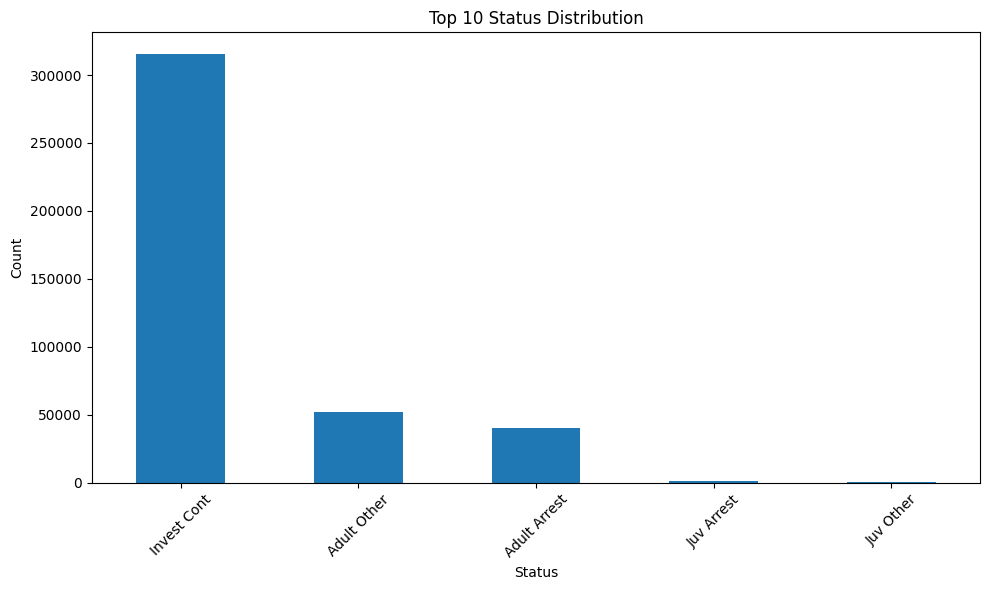

In [10]:
plt.figure(figsize=(10, 6))
status_counts[:10].plot(kind='bar')
plt.title('Top 10 Status Distribution')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
df = df.drop_duplicates()

# 4. Data Cleaning and Preprocessing

Cleaning the data by removing duplicates and handling date/time columns.


Converting 'DATE OCC' to datetime objects and extract temporal features like year, month, day.

In [12]:
print(f"\nShape before dropping duplicates: {df.shape}")
df = df.drop_duplicates()
print(f"Shape after dropping duplicates: {df.shape}")


Shape before dropping duplicates: (409718, 28)
Shape after dropping duplicates: (409718, 28)


Convert DATE OCC to datetime, coercing errors

In [13]:
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')
df.dropna(subset=['DATE OCC'], inplace=True)


<ipython-input-13-d598cf1d813e>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')


In [14]:
df['Occ_Year'] = df['DATE OCC'].dt.year
df['Occ_Month'] = df['DATE OCC'].dt.month
df['Occ_Day'] = df['DATE OCC'].dt.day


Extract hour from TIME OCC handling potential non-integer or malformed times

In [15]:
df['Occ_Hour'] = df['TIME OCC'].apply(lambda x: int(str(x).zfill(4)[:2]) if str(x).zfill(4)[:2].isdigit() else -1)
df = df[df['Occ_Hour'] != -1]

Defining time bins and labels for 'Timeframe'

In [16]:
bins = [-1, 6, 12, 18, 24] # Adjusted bins for clearer categories
labels = ['Midnight-6am', '6am-12pm', '12pm-6pm', '6pm-Midnight']
df['Timeframe'] = pd.cut(df['Occ_Hour'], bins=bins, labels=labels, right=False, include_lowest=True)

Create the target variable 'Arrest Made' based on 'Status Desc'.

Select relevant features for modeling and handle missing values in the selected subset.

Encode categorical features using LabelEncoder.

Create binary 'Arrest Made' variable (1 if arrest, 0 otherwise

In [17]:
arrest_categories = ['Adult Arrest', 'Juv Arrest']
df['Arrest Made'] = df['Status Desc'].isin(arrest_categories).astype(int)

In [18]:
keep_features = [
    'AREA', 'Rpt Dist No', 'Crm Cd', 'Vict Age', 'Vict Sex', 'Vict Descent',
    'Premis Cd', 'LAT', 'LON', 'Timeframe', 'Occ_Year', 'Occ_Month', 'Occ_Day',
    'Arrest Made'
]
df = df[keep_features]


In [19]:
print(f"\nShape before dropping NaN: {df.shape}")
df = df.dropna()
print(f"Shape after dropping NaN: {df.shape}")



Shape before dropping NaN: (409718, 14)
Shape after dropping NaN: (355869, 14)


Encode categorical features

In [20]:
le = LabelEncoder()
categorical_cols = ['Vict Sex', 'Vict Descent', 'Timeframe']
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [21]:
print("\nFinal preprocessed DataFrame info:")
df.info()



Final preprocessed DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 355869 entries, 0 to 409716
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   AREA          355869 non-null  int64  
 1   Rpt Dist No   355869 non-null  int64  
 2   Crm Cd        355869 non-null  int64  
 3   Vict Age      355869 non-null  int64  
 4   Vict Sex      355869 non-null  int64  
 5   Vict Descent  355869 non-null  int64  
 6   Premis Cd     355869 non-null  float64
 7   LAT           355869 non-null  float64
 8   LON           355869 non-null  float64
 9   Timeframe     355869 non-null  int64  
 10  Occ_Year      355869 non-null  int32  
 11  Occ_Month     355869 non-null  int32  
 12  Occ_Day       355869 non-null  int32  
 13  Arrest Made   355869 non-null  int64  
dtypes: float64(3), int32(3), int64(8)
memory usage: 36.7 MB


Preparing Data for Classification & Handle Imbalance

Separate features (X) and the target variable (y).

Splitting the data into training and testing sets.

Applying Synthetic Minority Over-sampling Technique (SMOTE) to the training data to address class imbalance in the 'Arrest Made' variable.


In [22]:
X = df.drop('Arrest Made', axis=1)
y = df['Arrest Made']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)

print("\nOriginal training set class distribution:\n", y_train.value_counts())



Original training set class distribution:
 Arrest Made
0    253377
1     31318
Name: count, dtype: int64


In [24]:
smote = SMOTE(random_state=4)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("\nResampled training set shape:", X_res.shape)
print("Resampled training set class distribution:\n", pd.Series(y_res).value_counts())


Resampled training set shape: (506754, 13)
Resampled training set class distribution:
 Arrest Made
0    253377
1    253377
Name: count, dtype: int64


Dimensionality Reduction and Visualization (PCA)

Applying Principal Component Analysis (PCA) to reduce the dimensionality of the feature space to 2 components for visualization.

Plotting the original and SMOTE-resampled training data in the PCA-reduced space to visualize the effect of SMOTE.



In [27]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_res_pca = pca.transform(X_res)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


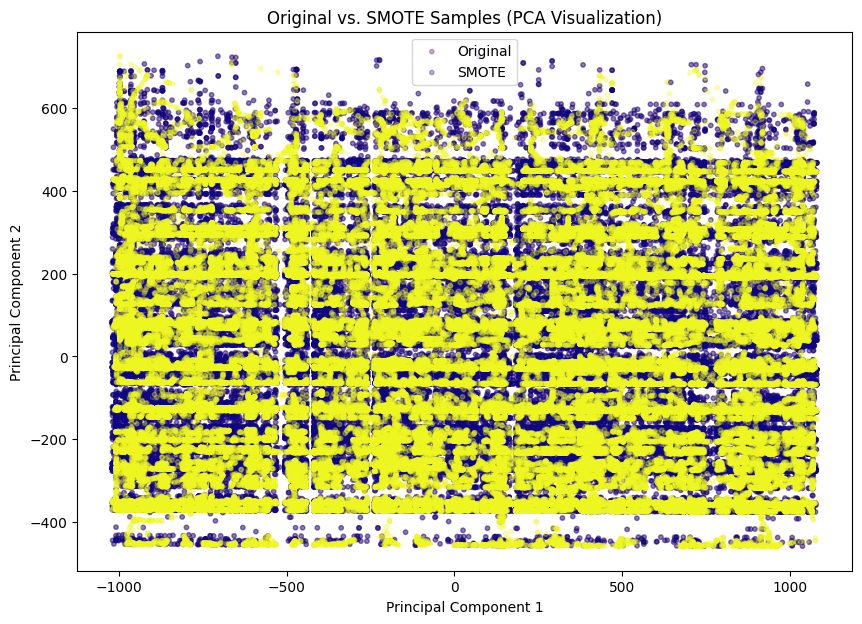

In [28]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', label='Original', alpha=0.3, s=10)
plt.scatter(X_res_pca[:, 0], X_res_pca[:, 1], c=y_res, cmap='plasma', label='SMOTE', alpha=0.3, s=10) # Different color map for SMOTE
plt.legend()
plt.title('Original vs. SMOTE Samples (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

Crime Hotspot Identification (DBSCAN Clustering)

In [29]:
print("\nRunning DBSCAN for hotspot identification...")
db = DBSCAN(eps=0.01, min_samples=10, n_jobs=-1).fit(df[['LAT', 'LON']])
df['Cluster'] = db.labels_
print(f"Number of clusters found: {len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)}")
print(f"Number of noise points (Cluster -1): {(db.labels_ == -1).sum()}")


Running DBSCAN for hotspot identification...
Number of clusters found: 4
Number of noise points (Cluster -1): 27


Visualize the clusters using a scatter plot.

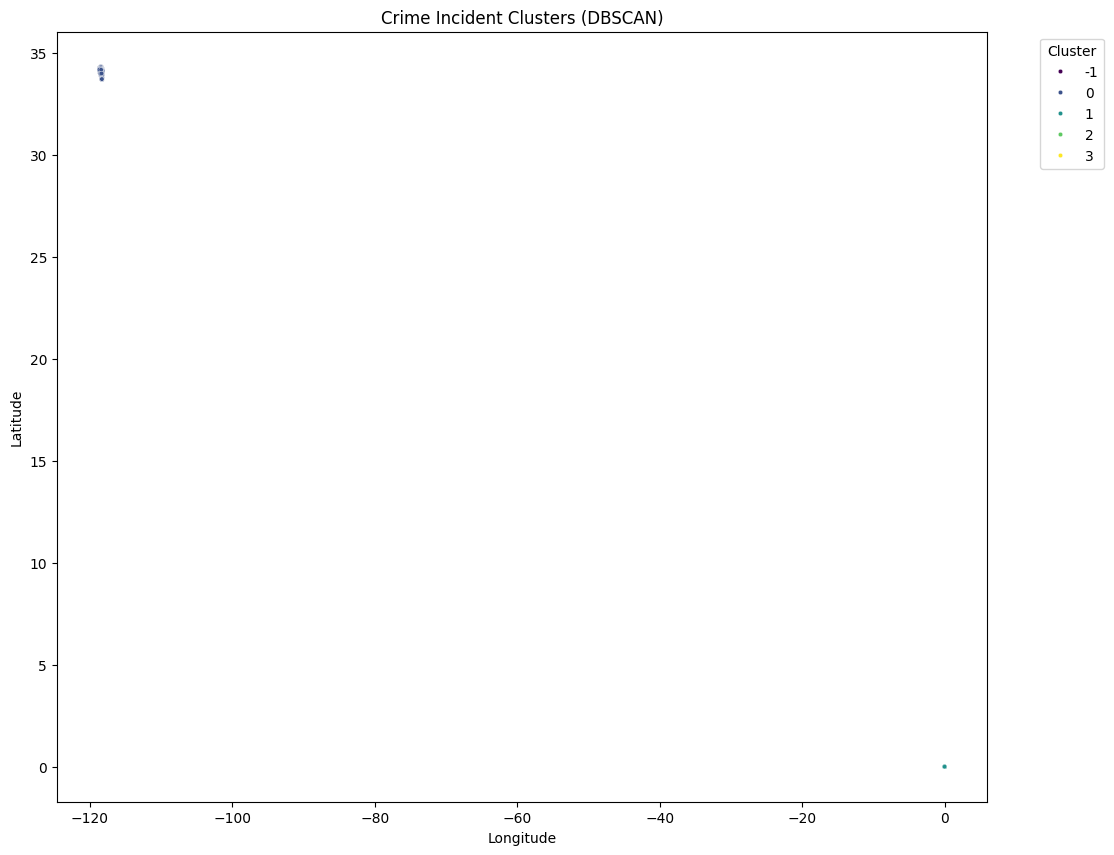

In [30]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df, x='LON', y='LAT', hue='Cluster', palette='viridis', s=10, legend='full')
plt.title('Crime Incident Clusters (DBSCAN)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [31]:
print("\nGenerating Folium HeatMap...")


Generating Folium HeatMap...


Crime Hotspot Map Visualization (Folium)

In [33]:
map_center = [df['LAT'].mean(), df['LON'].mean()]
crime_map = folium.Map(location=map_center, zoom_start=11)

heat_data = df[['LAT', 'LON']].values.tolist()
HeatMap(heat_data, radius=10, blur=15).add_to(crime_map)
crime_map

In [34]:
time_area_crosstab = pd.crosstab(df['Timeframe'], df['AREA'])
print("\nTimeframe vs. AREA Cross-tabulation:\n", time_area_crosstab)


Timeframe vs. AREA Cross-tabulation:
 AREA         1     2     3     4     5     6     7     8     9     10  ...  \
Timeframe                                                              ...   
0          7278  5025  6624  4172  4769  6519  6268  6338  5110  4898  ...   
1          4953  3337  4279  2503  3053  4034  3495  3733  3066  3005  ...   
2          7038  5016  6025  4125  4693  5988  5046  4950  4596  4407  ...   
3          3830  2505  2784  2110  2556  3768  2318  2510  2400  2367  ...   

AREA         12    13    14    15    16    17    18    19    20    21  
Timeframe                                                              
0          7310  5375  7130  6163  4063  5214  5683  4588  5626  5357  
1          4673  3318  4375  3705  2469  2972  3518  2770  3739  2985  
2          6957  4957  6524  5583  3587  4193  5744  4357  5404  4504  
3          3717  2629  3244  3051  1696  1996  2809  2115  3052  2087  

[4 rows x 21 columns]


In [ ]:
print("\nTraining Data Shape After SMOTE:", X_res.shape)
print("Class Distribution in Resampled Training Data:\n", pd.Series(y_res).value_counts())

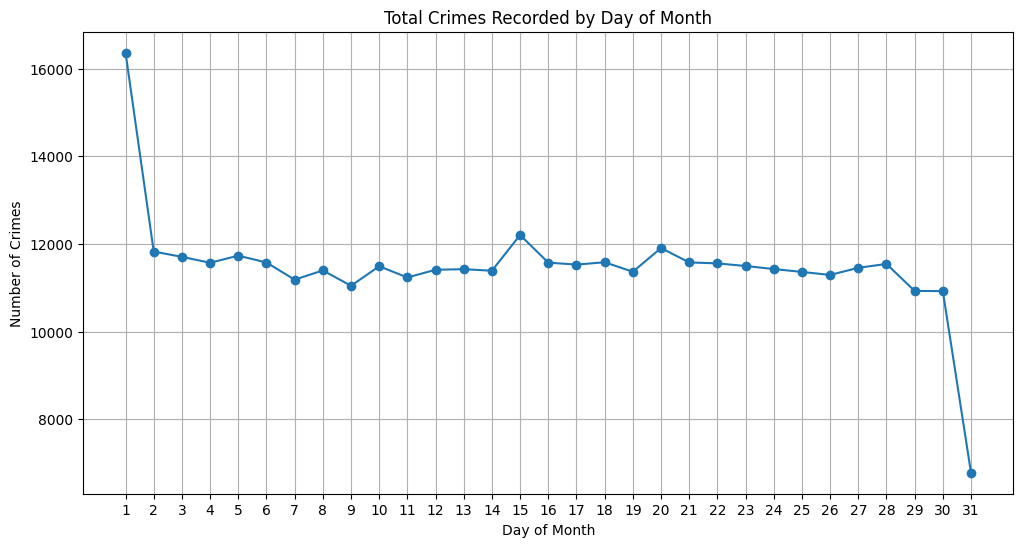

In [35]:
plt.figure(figsize=(12, 6))
df.groupby('Occ_Day')['Arrest Made'].count().plot(kind='line', marker='o')
plt.title('Total Crimes Recorded by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.xticks(range(1, 32))
plt.show()


In [37]:
print("\nTraining Baseline Model (Decision Tree)...")
baseline_features = ['AREA', 'Rpt Dist No', 'Crm Cd', 'Timeframe']
X_base = df[baseline_features]
y_base = df['Arrest Made']


Training Baseline Model (Decision Tree)...


In [38]:
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(
    X_base, y_base, test_size=0.2, random_state=4, stratify=y_base # Added stratify
)

In [39]:
smote_base = SMOTE(random_state=4)
X_base_res, y_base_res = smote_base.fit_resample(X_base_train, y_base_train)

print("Resampled baseline training set shape:", X_base_res.shape)
print("Resampled baseline class distribution:\n", pd.Series(y_base_res).value_counts())

Resampled baseline training set shape: (506754, 4)
Resampled baseline class distribution:
 Arrest Made
0    253377
1    253377
Name: count, dtype: int64


Baseline Predictive Model (Decision Tree)

In [41]:
from sklearn.tree import DecisionTreeClassifier


In [42]:
dt_base = DecisionTreeClassifier(random_state=4)
dt_base.fit(X_base_res, y_base_res)


DecisionTreeClassifier(random_state=4)

In [43]:
y_base_pred = dt_base.predict(X_base_test)
print("\nBaseline Model Performance (Decision Tree):\n", classification_report(y_base_test, y_base_pred))


Baseline Model Performance (Decision Tree):
               precision    recall  f1-score   support

           0       0.93      0.79      0.85     63345
           1       0.22      0.50      0.31      7829

    accuracy                           0.75     71174
   macro avg       0.57      0.64      0.58     71174
weighted avg       0.85      0.75      0.79     71174



In [44]:
print("\nTraining Enhanced Model (Random Forest)...")
df['Hotspot'] = (df['Cluster'] != -1).astype(int)


Training Enhanced Model (Random Forest)...


In [47]:
enhanced_features = [col for col in keep_features if col != 'Arrest Made'] + ['Hotspot']

In [48]:
if 'Cluster' in enhanced_features:
    enhanced_features.remove('Cluster')

X_enh = df[enhanced_features]
y_enh = df['Arrest Made']

X_enh_train, X_enh_test, y_enh_train, y_enh_test = train_test_split(
    X_enh, y_enh, test_size=0.2, random_state=4, stratify=y_enh
)


In [49]:
smote_enh = SMOTE(random_state=4)
X_enh_res, y_enh_res = smote_enh.fit_resample(X_enh_train, y_enh_train)

print("Resampled enhanced training set shape:", X_enh_res.shape)
print("Resampled enhanced class distribution:\n", pd.Series(y_enh_res).value_counts())

Resampled enhanced training set shape: (506754, 14)
Resampled enhanced class distribution:
 Arrest Made
0    253377
1    253377
Name: count, dtype: int64


In [50]:
rf_enh = RandomForestClassifier(random_state=4, n_jobs=-1)
rf_enh.fit(X_enh_res, y_enh_res)

y_enh_pred = rf_enh.predict(X_enh_test)
print("\nEnhanced Model Performance (Random Forest):\n", classification_report(y_enh_test, y_enh_pred))


Enhanced Model Performance (Random Forest):
               precision    recall  f1-score   support

           0       0.91      0.94      0.93     63345
           1       0.36      0.27      0.31      7829

    accuracy                           0.87     71174
   macro avg       0.64      0.61      0.62     71174
weighted avg       0.85      0.87      0.86     71174



In [51]:
print("\nPreparing Data for Spatio-Temporal Model (LSTM)...")
daily_data = df.groupby(['Occ_Year', 'Occ_Month', 'Occ_Day']).agg(
    Arrest_Occurred = ('Arrest Made', lambda x: int(x.sum() > 0)),
    Mean_LAT = ('LAT', 'mean'),
    Mean_LON = ('LON', 'mean'),
    Hotspot_Ratio = ('Hotspot', 'mean'),
    Crime_Count = ('AREA', 'count')
).reset_index()

print(f"Daily aggregated data shape: {daily_data.shape}")


Preparing Data for Spatio-Temporal Model (LSTM)...
Daily aggregated data shape: (731, 8)


In [53]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import folium
from folium.plugins import HeatMap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Spatio-Temporal Predictive Model (LSTM) - Experimental

In [54]:
lstm_features = ['Mean_LAT', 'Mean_LON', 'Hotspot_Ratio', 'Crime_Count']
lstm_target = 'Arrest_Occurred'

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(daily_data[lstm_features])

scaled_data_with_target = np.hstack((daily_data[[lstm_target]].values, scaled_features))

def create_sequences(data, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length, 1:])
        y_seq.append(data[i+seq_length, 0])
    return np.array(X_seq), np.array(y_seq)

In [55]:
seq_length = 7
X_seq, y_seq = create_sequences(scaled_data_with_target, seq_length)

print(f"Shape of sequence features (X_seq): {X_seq.shape}")
print(f"Shape of sequence target (y_seq): {y_seq.shape}")
print(f"Class distribution in LSTM target (y_seq):\n{pd.Series(y_seq).value_counts(normalize=True)}")

Shape of sequence features (X_seq): (724, 7, 4)
Shape of sequence target (y_seq): (724,)
Class distribution in LSTM target (y_seq):
1.0    1.0
Name: proportion, dtype: float64


In [56]:
X_seq_train, X_seq_test, y_seq_train, y_seq_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=4
)


In [57]:
print("\nBuilding and Training LSTM Model...")
# Define LSTM model architecture
lstm_model = Sequential([
    LSTM(50, input_shape=(seq_length, X_seq.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


Building and Training LSTM Model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [58]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 50)               │          11,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
history = lstm_model.fit(X_seq_train, y_seq_train,
                         epochs=20,
                         batch_size=52,
                         validation_split=0.02,
                         verbose=1)

print("\nEvaluating LSTM Model...")
loss, accuracy = lstm_model.evaluate(X_seq_test, y_seq_test, verbose=0)
print(f"LSTM Test Loss: {loss:.4f}")
print(f"LSTM Test Accuracy: {accuracy:.4f}")

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.3889e-05 - val_accuracy: 1.0000 - val_loss: 8.0223e-06
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.1589e-05 - val_accuracy: 1.0000 - val_loss: 7.9648e-06
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.2057e-05 - val_accuracy: 1.0000 - val_loss: 7.9084e-06
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.4233e-05 - val_accuracy: 1.0000 - val_loss: 7.8499e-06
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.2894e-05 - val_accuracy: 1.0000 - val_loss: 7.7916e-06
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.2551e-05 - val_accuracy: 1.0000 - val_loss: 7.7336e-06
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.3309e-05 - val_accuracy: 1.0000 - val_loss: 7.6750e-06
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - ac

In [77]:
y_seq_pred_prob = lstm_model.predict(X_seq_test)
y_seq_pred = (y_seq_pred_prob > 0.5).astype(int)

print("\nSpatio-Temporal Model (LSTM) Performance:\n", classification_report(y_seq_test, y_seq_pred))

plt.figure(figsize=(12, 4))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Spatio-Temporal Model (LSTM) Performance:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       145

    accuracy                           1.00       145
   macro avg       1.00      1.00      1.00       145
weighted avg       1.00      1.00      1.00       145



<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

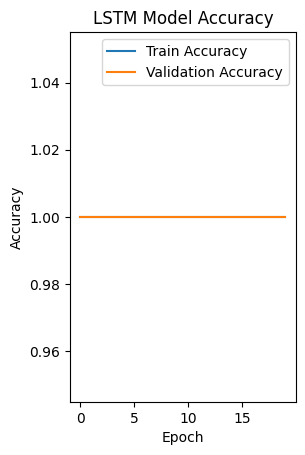

In [78]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


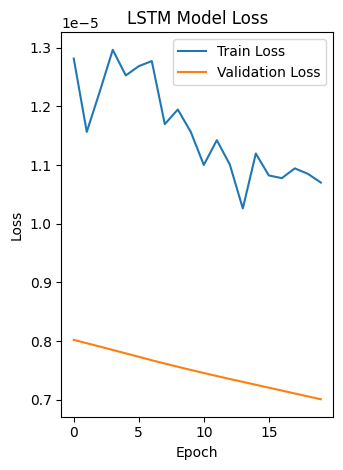

In [79]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()